In [38]:
"""
================================================
Example 10: 2D Low Frequency + 3D High Frequency
================================================
"""

import numpy as np

from drdmannturb.fluctuation_generation.fluctuation_field_generator import FluctuationFieldGenerator
from drdmannturb.fluctuation_generation.low_frequency.fluctuation_field_generator import LowFreqGenerator

##############################
# 2d low-frequency parameters
L2D = 15_000.0
sigma2 = 5
z_i = 500.0
psi = np.deg2rad(45.0)

_grid_dimensions_3d = np.array([
    1000,
    3 * L2D,
    z_i,
])


_grid_dimensions_2d = np.array([
    6 * L2D,
    6 * L2D,
])

_grid_levels = np.array([ # NOTE: isotropic in xy-plane, not z-direction
        12,
        9,
        4,
])

# Generate 2D low-frequency field
config_2d = {
    "sigma2": sigma2,
    "L_2d": L2D,
    "z_i": z_i,
    "psi": psi,

    "L1_factor": _grid_dimensions[0] / L2D,
    "L2_factor": _grid_dimensions[1] / L2D,
    "N1": _grid_levels[0],
    "N2": _grid_levels[1],
}

low_freq_gen = LowFreqGenerator(config_2d)

lowfreq_u, lowfreq_v = low_freq_gen.generate()



###################
# 3d parameters
z0 = 0.02
zref = 90
uref = 11.4
ustar = uref * 0.41 / np.log(zref / z0)
plexp = 0.2
windprofiletype = "PL"

# Mann model parameters (still 3d)
L = 50
Gamma = 2.5
sigma = 0.01

# Generate 3d high-frequency field
gen_mann = FluctuationFieldGenerator(
    ustar,
    z_i,
    grid_dimensions = _grid_dimensions,
    grid_levels = _grid_levels,
    length_scale = L,
    time_scale = Gamma,
    energy_spectrum_scale = sigma,
    model = "Mann",
    seed = None,
)


field_3d = gen_mann.generate(1, zref, uref, z0, windprofiletype, plexp)

field_2d3d = field_3d.copy()
field_2d3d[:-1, :-1, :, 0] += lowfreq_u[..., np.newaxis]
field_2d3d[:-1, :-1, :, 1] += lowfreq_v[..., np.newaxis]



Calculating 'c' using 2D integral (polar coordinates)...
  Using dblquad limits: k in [0.0e+00, 1.0e+01], theta in [0, 2*pi]
  2D Integral (polar) result: 1.143948e+03, Est. Error: 3.79e-11
Using c (from 2D polar integration): 4.370827e-03


In [6]:
halfwayup = field_2d3d.shape[2] // 2

In [7]:
low_freq_gen.u1 = field_2d3d[:, :, halfwayup, 0]
low_freq_gen.u2 = field_2d3d[:, :, halfwayup, 1]

In [9]:
low_freq_gen.u1 = field_3d[:, :, halfwayup, 0]
low_freq_gen.u2 = field_3d[:, :, halfwayup, 1]

In [41]:
magnitude_2d3d = np.linalg.norm(field_2d3d, axis=-1)
magnitude_3d = np.linalg.norm(field_3d, axis=-1)



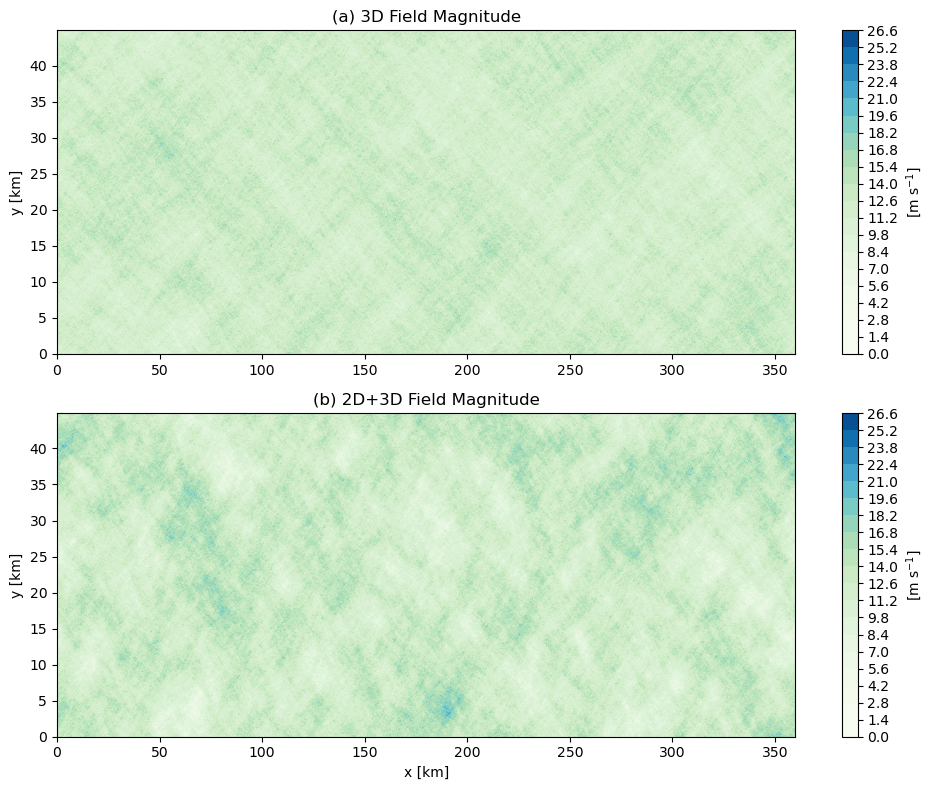

In [43]:
# Get coordinates in kilometers (assuming your spacing is in meters)
spacing = _grid_dimensions / (2**_grid_levels + 1)
x = np.arange(magnitude_3d.shape[0]) * spacing[0] / 1000  # convert to km
y = np.arange(magnitude_3d.shape[1]) * spacing[1] / 1000

# Create figure with two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

z_level = 3

# Create meshgrid for contour plots
X, Y = np.meshgrid(x, y)

# Create levels for original (non-squared) values
orig_levels = np.linspace(np.min(magnitude_3d), np.max(magnitude_2d3d), 20)

# Square the values but keep original levels for colorbar
# Choose either squared or cubed by uncommenting the desired version:
power = 2  # for squared
# power = 3  # for cubed

# Convert levels to squared/cubed space
levels = orig_levels**power

# Plot 3D field magnitude
im1 = ax1.contourf(X, Y, magnitude_3d[:,:,z_level].T**power, levels=levels, cmap="GnBu")
# Format colorbar to show original (non-squared) values
cbar1 = plt.colorbar(im1, ax=ax1, ticks=levels)
cbar1.ax.set_yticklabels([f'{l:.1f}' for l in orig_levels])
cbar1.set_label("[m s$^{-1}$]")
ax1.set_ylabel("y [km]")
ax1.set_title("(a) 3D Field Magnitude")

# Plot 2D+3D field magnitude
im2 = ax2.contourf(X, Y, magnitude_2d3d[:,:,z_level].T**power, levels=levels, cmap="GnBu")
# Format colorbar to show original (non-squared) values
cbar2 = plt.colorbar(im2, ax=ax2, ticks=levels)
cbar2.ax.set_yticklabels([f'{l:.1f}' for l in orig_levels])
cbar2.set_label("[m s$^{-1}$]")
ax2.set_xlabel("x [km]")
ax2.set_ylabel("y [km]")
ax2.set_title("(b) 2D+3D Field Magnitude")

# Adjust layout
plt.tight_layout()
plt.show()